In [31]:
import numpy as np
from math import exp, sin, cos, sqrt, radians, floor

import matplotlib.pyplot as plt
import matplotlib.animation

Let's first set up some constants.   
Don't change anything here.  

In [32]:
J_B_s = np.array([ [100,0,0], [0,100,0], [0,0,300] ]) # total moment of inertia of the satellite, kg*m^2
J_II = 0.01044 * np.eye(4) # moment of inertial matrix for the wheels
inv_J_II = np.linalg.inv(J_II)
W = 0.5*np.array([  [1, 1, -1, -1], 
                    [-1, 1, 1, -1], 
                    [sqrt(2), sqrt(2), sqrt(2), sqrt(2)] ]) # a set of unit vectors along the spin axes of the wheels in the satellite body frame
W_T = np.transpose(W)
J_B = J_B_s - W@J_II@W_T
inv_J = np.linalg.inv(J_B)
W_p = W_T @ np.linalg.inv(W@W_T) # pseduo inverse of W

Some utility functions.  
Don't change anything here.  

In [33]:
def q_to_a(q):
    """
        quaternion to rotation matrix  
        @param q: quaternion  
        @param A: rotation matrix 
    """
    q_1 = q[0]
    q_2 = q[1]
    q_3 = q[2]
    q_4 = q[3]
    
    A = np.array([  [q_1**2 - q_2**2 - q_3**2 + q_4**2, 2*(q_1*q_2 + q_3*q_4), 2*(q_1*q_3 - q_2*q_4)],
                    [2*(q_2*q_1 - q_3*q_4), -q_1**2 + q_2**2 - q_3**2 + q_4**2, 2*(q_2*q_3 + q_1*q_4)],
                    [2*(q_3*q_1 + q_2*q_4), 2*(q_3*q_2 - q_1*q_4), -q_1**2 -q_2**2 + q_3**2 + q_4**2] ])

    return A


def q_dot(q, w):
    """
        derivative of a quaternion
    """

    q_1 = q[0]
    q_2 = q[1]
    q_3 = q[2]
    q_4 = q[3]
    
    # quaternion kinematics #
    # w represents angular velocity w_{B}^{BI}
    # quaternion represent a rotation matrix A_BI
    q_dot = (1/2) * np.array([  [q_4, -q_3, q_2 ], 
                                [q_3, q_4, -q_1], 
                                [-q_2, q_1, q_4], 
                                [-q_1, -q_2, -q_3]  ]) @ w

    return q_dot


Reaction wheel dynamics.  
### YOU NEED TO COMPLETE THIS

In [34]:
def Dynamics(omega, omega_w, L_B, L_w, dt):

    omega_dot = np.linalg.inv(J_B_s - W @ J_II @ W_T) @ (L_B - W @ L_w - np.cross(omega, (J_B_s @ omega + W @ J_II @ omega_w)))
    omega_w_dot = np.linalg.inv(J_II) @ L_w - W_T @ omega_dot

    return dt*omega_dot, dt*omega_w_dot # output increaments for RK4

RK4.  
Don't change anything here.

In [35]:
def rk4(L_B, L_w, omega, omega_w, q, dt):
    """
        4th fixed step runge-kutta attitude simulator
    """

    k1, k1_w = Dynamics( omega,            omega_w,                L_B, L_w, dt )
    k2, k2_w = Dynamics( omega + 0.5*k1,   omega_w + 0.5*k1_w,     L_B, L_w, dt )
    k3, k3_w = Dynamics( omega + 0.5*k2,   omega_w + 0.5*k2_w,     L_B, L_w, dt )
    k4, k4_w = Dynamics( omega + 1.0*k3,   omega_w + 1.0*k3_w,     L_B, L_w, dt )

    k1q = dt * q_dot( q,            omega )
    k2q = dt * q_dot( q + 0.5*k1q,  omega + 0.5*k1 )
    k3q = dt * q_dot( q + 0.5*k2q,  omega + 0.5*k2 )
    k4q = dt * q_dot( q + 1.0*k3q,  omega + k3 )

    omega = omega + (1/6) * ( k1 + 2*k2 + 2*k3 + k4 )
    omega_w = omega_w + (1/6) * (k1_w + 2*k2_w + 2*k3_w + k4_w)

    q = q + (1/6) * ( k1q + 2*k2q + 2*k3q + k4q )
    #renormalize quaternions
    q = q / np.linalg.norm(q)

    H_i = np.transpose(q_to_a(q)) @ (J_B_s@omega + W@J_II@omega_w)

    return omega, omega_w, q, H_i

Reaction wheel controller.  
### YOU NEED TO COMPLETE THIS

In [36]:
# Define a function to create a cross product matrix for a vector q --> [q x]
def cross_product_matrix(q):
    cross_product_matrix = np.array([[0, -q[2], q[1]],
                                     [q[2], 0, -q[0]],
                                     [-q[1], q[0], 0]])

    return cross_product_matrix
    
# Define a function which calculates the "circle cross" product of 2 quaternions, q and p --> q (x) p
def circle_cross(q, p):
    q_vec = q[:3]
    p_vec = p[:3]
    Q = cross_product_matrix(q_vec) 

    top = q[3]*p_vec + p[3]*q_vec - Q @ p_vec
    bottom = q[3]*p[3] - np.dot(q_vec, p_vec)

    # now stack into a single length-4 array
    return np.hstack((top, bottom))

def controller(q_c, q, omega, omega_w):

    k_p = 0.01
    k_d = 0.75

    limit = 1570 # saturation limit, rad/s. common motor 15000RPM (1570 rad/s) https://www.convertunits.com/from/RPM/to/radian/second
    tolerance = 100 

    q_conjugate = np.array((-q[0], -q[1], -q[2], q[3]))
    
    dq = circle_cross(q_c, q_conjugate)
    
    L_w = W_p @ (np.cross(-omega, J_B_s @ omega + W @ J_II @ omega_w) + (k_p) * np.sign(dq[3]) * (J_B @ q[:3]) + k_d * J_B @ omega)

    # Saturation check
    for kk in range(4):
        if abs(omega_w[kk]) >= (limit - tolerance):
            if np.sign(L_w[kk]) == np.sign(omega_w[kk]):
                L_w[kk] = 0
                
    return L_w 

### FUNCTION TO CONVERT QUATERNION TO 3-2-1 EULER ANGLES

In [37]:
def quat_to_euler321(q):
    """
    Quaternion (vector part first, scalar last) to 3‑2‑1 (roll‑pitch‑yaw) Euler angles.
    Returns (phi, theta, psi) in radians.
    """
    q1, q2, q3, q4 = q
    # roll (phi)
    phi = np.arctan2(2*(q4*q1 + q2*q3), 1 - 2*(q1**2 + q2**2))
    
    # pitch (theta)
    theta = np.arcsin(2*(q4*q2 - q3*q1))
    
    # yaw (psi)
    psi = np.arctan2( 2*(q4*q3 + q1*q2), 1 - 2*(q2**2 + q3**2))
    return phi, theta, psi


def rad2deg(arr):
    return np.asarray(arr)*180.0/np.pi

### DEFINE CONSTANTS FOR ORBITAL STUFF

In [38]:
# Earth/orbit geometry
r_E = 6.378e6 # Earth radius (m)
h1 = 250e3 # Region 1 - 250 km altitude (m)
h2 = 500e3 # Region 2 - 500 km altitude (m)
h3 = 800e3 # Region 3 - 800 km altitude (m)

# Orbital radius
a1 = r_E + h1 # Region 1 (m)
a2 = r_E + h2 # Region 2 (m)
a3 = r_E + h3 # Region 3 (m)

# Gravitational parameter
mu_E = 3.986004418e14 # (m^3/s^2)

# Circular velocity
v_circ1 = np.sqrt(mu_E/a1)
v_circ2 = np.sqrt(mu_E/a2)
v_circ3 = np.sqrt(mu_E/a3)

# Varying Altitudes Mean Densities
# from http://www.braeunig.us/space/atmos.htm
rho_250km = 5.97e-11  # (kg/m^3) 
rho_500km = 4.76e-13  # (kg/m^3) 
rho_800km = 6.95e-15  # (kg/m^3)

Cd = 2.2 # typical free-molecular flat plate C_d
A_ref = 1.0 # Reference area (m^2) ######## REPLACE WITH ACCURATE VALUE ########

# Flow geometry
u_I = np.array([-1, 0, 0]) # Unit vector for free stream velocity in inertial frame (negative x direction, opposite velocity)

# Body geometry
n_B = np.array([1, 0, 0]) # Normal of the body x-face, which is the surface experiencing the drag

### DEFINE CUBESAT GEOMETRY

In [39]:
# 1U dimensions: (0.1m x 0.1m x 0.1m)
L_cube = 0.10 # edge length (m)

# Moment arm, centroid is halfway
r_B_drag = np.array([L_cube/2, 0, 0])

Animation functions.  
Don't change anything here.

In [40]:
def plot_linear_cube(ax, x_I, color='red'):

    x = x_I[0,:]
    y = x_I[1,:]
    z = x_I[2,:]
    
    index = [   [0, 1, 2, 3],
                [4, 5, 6, 7],
                [0, 3, 7, 4], 
                [1, 2, 6, 5],
                [0, 1, 5, 4],
                [2, 3, 7, 6] ]
    kwargs = {'alpha': 1, 'color': color}

    for ii in range(len(index)):
        i = index[ii]
        ax.plot3D( [x[i[0]], x[i[1]], x[i[2]], x[i[3]], x[i[0]]], 
                    [y[i[0]], y[i[1]], y[i[2]], y[i[3]], y[i[0]]],
                    [z[i[0]], z[i[1]], z[i[2]], z[i[3]], z[i[0]]], **kwargs )


def animate(i, *fargs):
        ax = fargs[0]
        x_B = fargs[1]
        q_save = fargs[2]
        q_c = fargs[3]

        progress = "Animation Progress = " + str(floor((i/(60*10*30))*100)) + " %"
        print(progress, end="\r")

        ax.clear() # clear everything including axes limits
        ax.set_xlim3d(-2,2)
        ax.set_ylim3d(-2,2)
        ax.set_zlim3d(-2,2)

        #### LABEL AXES ####
        ax.set_xlabel('Body-X [m]')
        ax.set_ylabel('Body-Y [m]')
        ax.set_zlabel('Body-Z [m]')
    

        # rotate box using quaternion
        q = q_save[i]
        A_q = q_to_a(q)
        x_I_l = np.transpose(A_q) @ x_B
        plot_linear_cube(ax, x_I_l, 'blue')

        # plot current e3 axis under the inertial frame
        z_B = np.array([0, 0, 1])
        z_I = np.transpose(A_q) @ z_B
        ax.quiver(0, 0, 0, z_I[0], z_I[1], z_I[2], length= 3 , normalize=True, color='g' )
        ax.text(3*z_I[0], 3*z_I[1], 3*z_I[2], 'e3', color='g', fontsize=12)

        # plot desired e3 axis under the inertial frame
        A_q_c = q_to_a(q_c)
        z_c = np.transpose(A_q_c) @ z_B
        ax.quiver(0, 0, 0, z_c[0], z_c[1], z_c[2], length= 3 , normalize=True, color='r' )
        ax.text(3*z_c[0], 3*z_c[1], 3*z_c[2], 'command', color='r', fontsize=12)


        #### DISPLAY EULER ANGLES ####
        phi, theta, psi = quat_to_euler321(q) # radians
        roll, pitch, yaw = np.degrees([phi, theta, psi])
        ax.text2D(0.03, 0.95,
              f"Roll, φ = {roll:+6.1f}°\nPitch, θ = {pitch:+6.1f}°\nYaw, ψ = {yaw:+6.1f}°",
              transform=ax.transAxes,
              fontsize=10, verticalalignment='top',
              bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="k", alpha=0.7))	

        #### DISPLACE INCIDENCE ANGLE ####
        u_B = A_q @ u_I # flow in body frame
        cos_a = np.dot(u_B, n_B)
        alpha_deg = np.degrees(np.arccos(np.clip(cos_a, -1.0, 1.0)))
        ax.text2D(0.72, 0.95, f"α = {alpha_deg:5.1f}°",
                  transform=ax.transAxes, fontsize=11,
                  bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="k"))



# Torque-free 

In [41]:
def main():

    # initial conditions
    q =  np.array([  0.6953, 0.1531, 0.1531, 0.6853 ])  # initial quaternion.
    q_c = np.array([0, 0, 0, 1]) # command quaternion.
    w = np.array([ radians(0.1),  radians(0.1), radians(0.1)]) # angular velocity, rad/
    w_w = np.array([ 0, 0, 0, 0 ]) # a set of spinning rates of reaction wheels, rad/s
    L_B = np.zeros(3) # external torque    
    t = 0
    t_max = 120*10
    dt = 0.05
    t_save = [] # save time 
    q_save = [] # save quaternion 
    w_save = [] # save angular velocity
    w_w_save = []
    H_i_save = []


    while t <= t_max:
 
        L_w = controller(q_c, q, w, w_w)
        L_w = np.zeros_like(L_w)

        w, w_w, q, H_i = rk4(L_B, L_w, w, w_w, q, dt)

        t_save.append(t)
        q_save.append(q)
        w_save.append(w)
        w_w_save.append(w_w)
        H_i_save.append(H_i)

        t = t + dt

    
    q_save = np.asarray(q_save)
    w_save = np.asarray(w_save)
    w_w_save = np.asarray(w_w_save)
    H_i_save = np.asarray(H_i_save)
    # plot the results
    plt.figure(1)
    plt.subplot(3,1,1)
    plt.plot(t_save, q_save)
    plt.ylabel('Quaternion')
    plt.subplot(3,1,2)
    plt.plot(t_save, w_save)
    plt.ylabel('Angular Velocity')
    plt.subplot(3,1,3)
    plt.plot(t_save, w_w_save)
    plt.ylabel('Wheel Spinning Rate')
    # plot angular momentum
    plt.figure(2)
    plt.ylabel('Angular Momentum')
    plt.plot(t_save, H_i_save[:, 0], 'r', t_save, H_i_save[:, 1], 'g', t_save, H_i_save[:, 2], 'b', linewidth = 2)
    plt.ylabel('Inertial Angular Momentum',fontsize = 12)
    plt.grid(True)
    #plt.legend()

    plt.show()


    # animation loop
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')   
    x_B = np.array([    [0, 1, 1, 0, 0, 1, 1, 0], 
                        [0 ,0, 1, 1, 0, 0, 1, 1], 
                        [0, 0, 0, 0, 2, 2, 2, 2] ]).astype('float64')
    x_B[0,:] = x_B[0,:] - 0.5
    x_B[1,:] = x_B[1,:] - 0.5
    x_B[2,:] = x_B[2,:] - 1

    frames_array = np.arange(0 ,int(t_max/dt), 30)
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames_array, fargs=(ax, x_B, q_save, q_c))
    ani.save('./v5 torque_free.gif', writer='pillow', fps=30)

# Only disturbances

In [42]:
def main(rho, v_circ):

    # initial conditions
    q =  np.array([  0.6953, 0.1531, 0.1531, 0.6853 ])  # initial quaternion.
    q_c = np.array([0, 0, 0, 1]) # command quaternion.
    w = np.array([ radians(0.1),  radians(0.1), radians(0.1)]) # angular velocity, rad/s    
    w_w = np.array([ 0, 0, 0, 0 ]) # a set of spinning rates of reaction wheels, rad/s
    L_B = np.zeros(3) # external torque    
    t = 0
    t_max = 120*10
    dt = 0.05
    t_save = [] # save time 
    q_save = [] # save quaternion 
    w_save = [] # save angular velocity
    w_w_save = []
    H_i_save = []

    ##### LIST TO STORE EULER ANGLES #####
    euler_save = []

    ##### LIST TO STORE INCIDENCE ANGLES #####
    alpha_save = []
    

    while t <= t_max:

        A_BI = q_to_a(q)
        u_B = A_BI @ u_I # flow stream vector in body frame

        cos_alpha = np.dot(u_B, n_B) # cos(incidence angle)

        if cos_alpha > 0.0: # if plate is facing flow
            A_eff = A_ref * cos_alpha # projected area
            F_mag = 0.5 * rho * v_circ**2 * Cd * A_eff 
            F_B = -F_mag * u_B # drag oppposes stream
        else: 
            F_B = np.zeros(3)

        # Calculate torque (r x F)
        L_B = np.cross(r_B_drag, F_B)

        # Turn off controller
        L_w = controller(q_c, q, w, w_w)
        L_w = np.zeros_like(L_w)

        # 3) integrate
        w, w_w, q, H_i = rk4(L_B, L_w, w, w_w, q, dt)

        # 4) re-normalize quaternion
        q = q / np.linalg.norm(q)

        t_save.append(t)
        q_save.append(q)
        w_save.append(w)
        w_w_save.append(w_w)
        H_i_save.append(H_i)

        ##### CALCULATE AND SAVE EULER ANGLES #####
        euler_save.append(quat_to_euler321(q))

        ##### SAVE INCIDENCE ANGLE #####
        alpha_save.append(np.arccos(cos_alpha))

        t = t + dt

    
    q_save = np.asarray(q_save)
    w_save = np.asarray(w_save)
    w_w_save = np.asarray(w_w_save)
    H_i_save = np.asarray(H_i_save)

    ##### CONVERT TO DEGREES FOR PLOTTING #####
    euler_save = np.rad2deg(euler_save)
    alpha_save = np.rad2deg(alpha_save)
    
    # plot the results
    plt.figure(1)
    plt.subplot(3,1,1)
    plt.plot(t_save, q_save)
    plt.ylabel('Quaternion')
    plt.subplot(3,1,2)
    plt.plot(t_save, w_save)
    plt.ylabel('Angular Velocity')
    plt.subplot(3,1,3)
    plt.plot(t_save, w_w_save)
    plt.ylabel('Wheel Spinning Rate')
    # plot angular momentum
    plt.figure(2)
    plt.ylabel('Angular Momentum')
    plt.plot(t_save, H_i_save[:, 0], 'r', t_save, H_i_save[:, 1], 'g', t_save, H_i_save[:, 2], 'b', linewidth = 2)
    plt.ylabel('Inertial Angular Momentum',fontsize = 12)
    plt.grid(True)
    #plt.legend()


    ##### EULER ANGLES PLOT #####
    plt.figure(3, figsize=(6,4))
    plt.plot(t_save, euler_save[:,0], label='Roll ($\phi$)')
    plt.plot(t_save, euler_save[:,1], label=r'Pitch ($\theta$)')
    plt.plot(t_save, euler_save[:,2], label='Yaw ($\psi$)')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (deg)')
    plt.title('Body‑to‑Inertial Euler Angles (3‑2‑1)')
    plt.grid(True)
    plt.legend()

    ##### INCIDENCE ANGLE PLOT #####
    plt.figure(4, figsize=(6,3))
    plt.plot(t_save, alpha_save)
    plt.xlabel('Time (s)')
    plt.ylabel(r'Incidence angle $\alpha$ (deg)')
    plt.title('Flow‑Incidence Angle vs. Time')
    plt.grid(True)
    

    plt.show()


    # animation loop
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')   
    x_B = np.array([    [0, 1, 1, 0, 0, 1, 1, 0], 
                        [0 ,0, 1, 1, 0, 0, 1, 1], 
                        [0, 0, 0, 0, 2, 2, 2, 2] ]).astype('float64')
    x_B[0,:] = x_B[0,:] - 0.5
    x_B[1,:] = x_B[1,:] - 0.5
    x_B[2,:] = x_B[2,:] - 1

    frames_array = np.arange(0 ,int(t_max/dt), 30)
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames_array, fargs=(ax, x_B, q_save, q_c))
    ani.save('./v5 disturbances.gif', writer='pillow', fps=30)

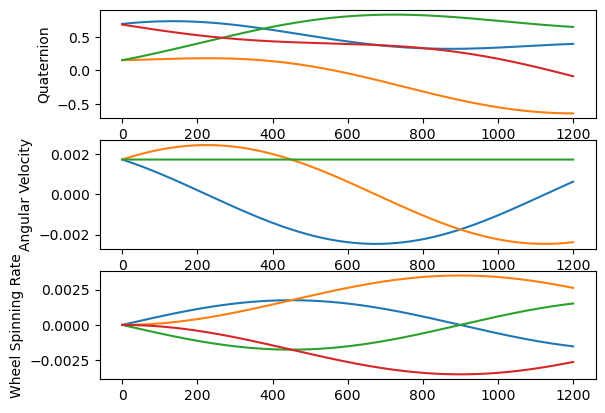

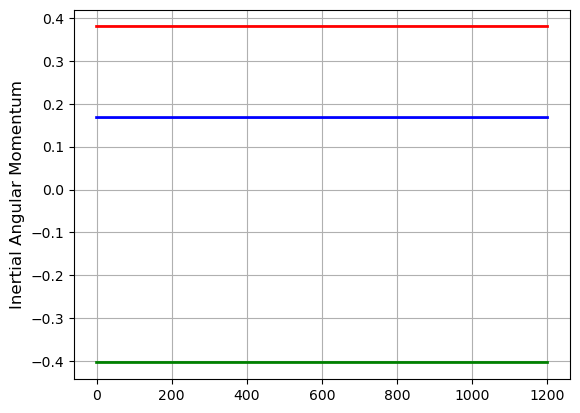

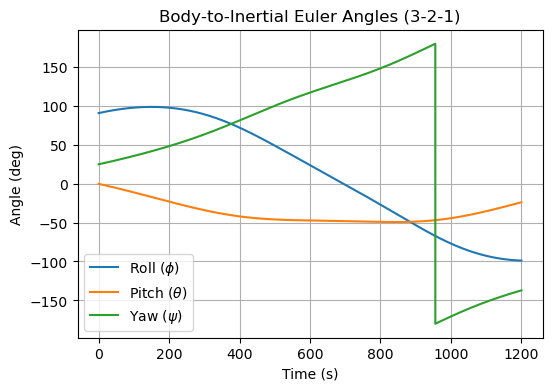

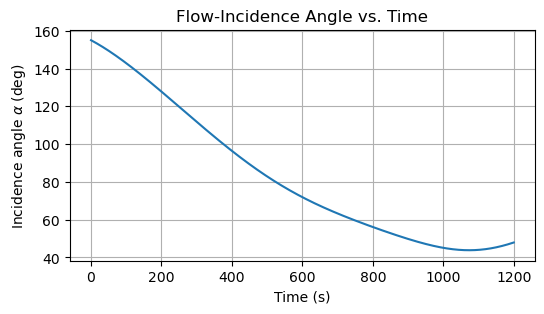

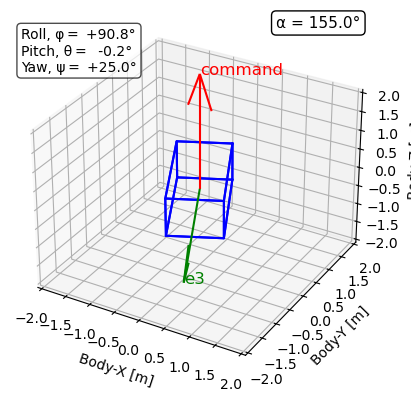

In [43]:
main(rho_800km, v_circ3)

# Controlled

In [44]:
def main(rho, v_circ):

    # initial conditions
    q =  np.array([  0.6953, 0.1531, 0.1531, 0.6853 ])  # initial quaternion.
    q_c = np.array([0, 0, 0, 1]) # command quaternion.
    
    w = np.array([ radians(0.1),  radians(0.1), radians(0.1)]) # angular velocity, rad/s
    
    w_w = np.array([ 0, 0, 0, 0 ]) # a set of spinning rates of reaction wheels, rad/s
    L_B = np.zeros(3) # external torque    
    t = 0
    t_max = 120*10
    dt = 0.05
    t_save = [] # save time 
    q_save = [] # save quaternion 
    w_save = [] # save angular velocity
    w_w_save = []
    H_i_save = []

    ##### LIST TO STORE EULER ANGLES #####
    euler_save = []

    ##### LIST TO STORE INCIDENCE ANGLES #####
    alpha_save = []


    while t <= t_max:

        A_BI = q_to_a(q)
        u_B = A_BI @ u_I # flow stream vector in body frame

        cos_alpha = np.dot(u_B, n_B) # cos(incidence angle)

        if cos_alpha > 0.0: # if plate is facing flow
            A_eff = A_ref * cos_alpha # projected area
            F_mag = 0.5 * rho * v_circ**2 * Cd * A_eff 
            F_B = -F_mag * u_B # drag oppposes stream
        else: 
            F_B = np.zeros(3)

        # Wheel torque is ZERO until t > half, then PD control
        if t <= 0.5*t_max:
            L_w = np.zeros(4)
        else:
            L_w = controller(q_c, q, w, w_w)


        # 3) integrate
        w, w_w, q, H_i = rk4(L_B, L_w, w, w_w, q, dt)

        # 4) re-normalize quaternion
        q = q / np.linalg.norm(q)

        t_save.append(t)
        q_save.append(q)
        w_save.append(w)
        w_w_save.append(w_w)
        H_i_save.append(H_i)

        ##### CALCULATE AND SAVE EULER ANGLES #####
        euler_save.append(quat_to_euler321(q))

        ##### SAVE INCIDENCE ANGLE #####
        alpha_save.append(np.arccos(cos_alpha))

        t = t + dt

    
    q_save = np.asarray(q_save)
    w_save = np.asarray(w_save)
    w_w_save = np.asarray(w_w_save)
    H_i_save = np.asarray(H_i_save)

    ##### CONVERT TO DEGREES FOR PLOTTING #####
    euler_save = np.rad2deg(euler_save)
    alpha_save = np.rad2deg(alpha_save)
    
    
    # plot the results
    plt.figure(1)
    plt.subplot(3,1,1)
    plt.plot(t_save, q_save)
    plt.ylabel('Quaternion')
    plt.subplot(3,1,2)
    plt.plot(t_save, w_save)
    plt.ylabel('Angular Velocity')
    plt.subplot(3,1,3)
    plt.plot(t_save, w_w_save)
    plt.ylabel('Wheel Spinning Rate')
    # plot angular momentum
    plt.figure(2)
    plt.ylabel('Angular Momentum')
    plt.plot(t_save, H_i_save[:, 0], 'r', t_save, H_i_save[:, 1], 'g', t_save, H_i_save[:, 2], 'b', linewidth = 2)
    plt.ylabel('Inertial Angular Momentum',fontsize = 12)
    plt.grid(True)
    #plt.legend()

    ##### EULER ANGLES PLOT #####
    plt.figure(3, figsize=(6,4))
    plt.plot(t_save, euler_save[:,0], label='Roll ($\phi$)')
    plt.plot(t_save, euler_save[:,1], label=r'Pitch ($\theta$)')
    plt.plot(t_save, euler_save[:,2], label='Yaw ($\psi$)')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (deg)')
    plt.title('Body‑to‑Inertial Euler Angles (3‑2‑1)')
    plt.grid(True)
    plt.legend()

    ##### INCIDENCE ANGLE PLOT #####
    plt.figure(4, figsize=(6,3))
    plt.plot(t_save, alpha_save)
    plt.xlabel('Time (s)')
    plt.ylabel(r'Incidence angle $\alpha$ (deg)')
    plt.title('Flow‑Incidence Angle vs. Time')
    plt.grid(True)

    plt.show()


    # animation loop
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')   
    x_B = np.array([    [0, 1, 1, 0, 0, 1, 1, 0], 
                        [0 ,0, 1, 1, 0, 0, 1, 1], 
                        [0, 0, 0, 0, 2, 2, 2, 2] ]).astype('float64')
    x_B[0,:] = x_B[0,:] - 0.5
    x_B[1,:] = x_B[1,:] - 0.5
    x_B[2,:] = x_B[2,:] - 1

    frames_array = np.arange(0 ,int(t_max/dt), 30)
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames_array, fargs=(ax, x_B, q_save, q_c))
    ani.save('./v5 controlled.gif', writer='pillow', fps=30)

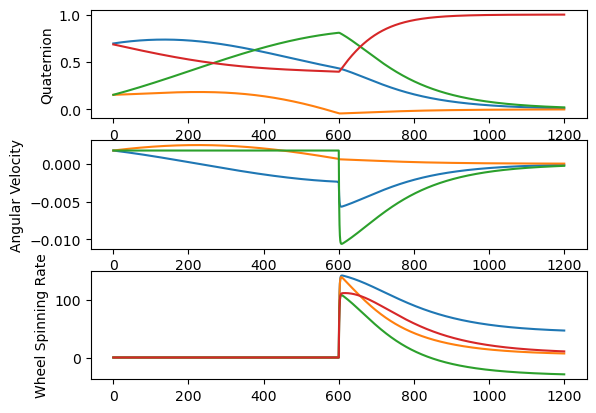

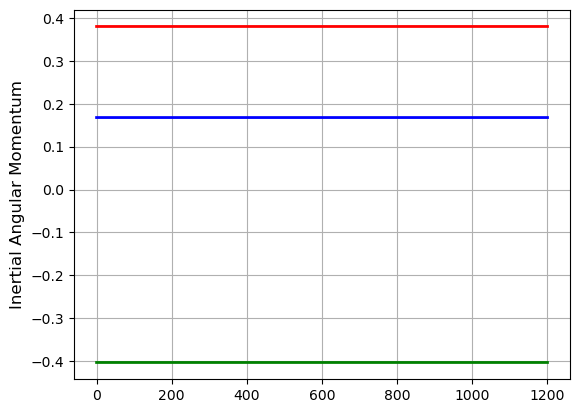

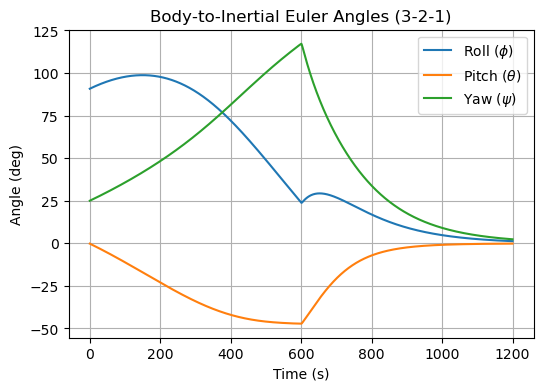

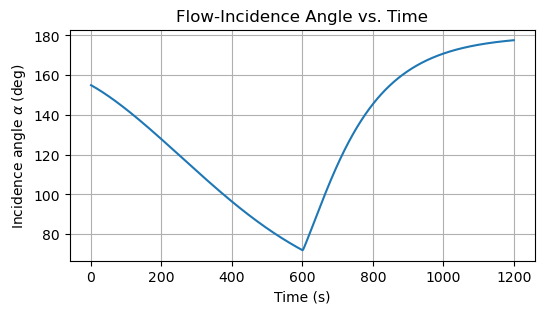

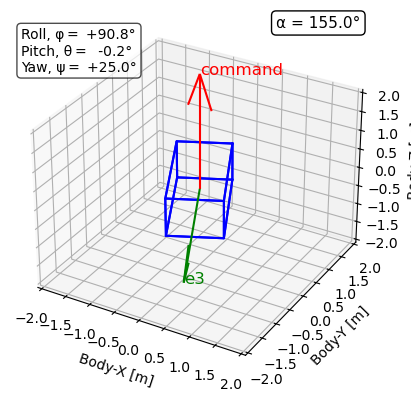

In [45]:
main(rho_800km, v_circ3)